In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from transformers import DistilBertConfig,RobertaConfig
from transformers import DistilBertTokenizer,DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification,DistilBertModel
from transformers import TFDistilBertForSequenceClassification,TFDistilBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras import regularizers
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

2022-12-02 09:43:43.104244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 09:43:43.104320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/titon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train= pd.read_csv('emotion_train.txt',delimiter=';',header=None,names=['sentence','label'])
test= pd.read_csv ('emotion_test.txt',delimiter=';',header=None,names=['sentence','label'])
valid= pd.read_csv('emotion_val.txt',delimiter=';',header=None, names=['sentence','label'])

In [4]:
df=pd.concat([train,test,valid])

In [47]:
label_count=df['label'].value_counts()
label=label_count.index
print(label)

Index(['joy', 'sadness', 'anger', 'fear', 'love', 'surprise'], dtype='object')


In [48]:
df['encoded_labels'] = df['label'].astype('category').cat.codes

In [62]:
df.head()

,sentence,label,nom_cluster,encoded_labels
0,i didnt feel humiliated,sadness,5,4
1,i can go from feeling so hopeless to so damned...,sadness,3,4
2,im grabbing a minute to post i feel greedy wrong,anger,1,0
3,i am ever feeling nostalgic about the fireplac...,love,2,3
4,i am feeling grouchy,anger,4,0


In [51]:
X = df['sentence']
y = df['encoded_labels']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

# Vectorisation du texte avec SentenceTransfomer de DistilBert

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

In [52]:
Corpus=X_train.tolist()

In [53]:
corpus_embeddings = model.encode(Corpus)

In [54]:
corpus_embeddings

array([[-1.0503995 ,  0.16797858,  0.23592865, ...,  0.4058892 ,
         0.09124447, -0.01935691],
       [-0.18051401,  0.53964734,  0.7971677 , ...,  0.87309456,
         0.5048571 ,  0.02480921],
       [-0.26759544, -0.10299555,  0.679299  , ...,  0.874107  ,
        -0.7825422 ,  0.3800878 ],
       ...,
       [-0.42330578,  0.08573675,  0.11589596, ...,  0.25265515,
        -0.5222074 , -0.50754374],
       [ 0.28957525,  0.05449409,  0.13408147, ..., -0.9346316 ,
        -0.1423304 ,  0.1006998 ],
       [-0.41066617,  0.03307354,  0.59523046, ..., -0.33884004,
        -0.2585812 ,  0.07383224]], dtype=float32)

In [55]:
corpus_embeddings.shape

(16000, 768)

In [59]:
#  k-means clusterin avec sklearn:
from sklearn.cluster import KMeans

num_clusters = 6
clustering_model = KMeans(n_clusters=num_clusters,random_state=0)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [60]:
clusters = clustering_model.predict(corpus_embeddings)

In [ ]:
df["nom_cluster"] = clusters

In [14]:
df.head(15)

,sentence,label,nom_cluster
0,i didnt feel humiliated,sadness,5
1,i can go from feeling so hopeless to so damned...,sadness,3
2,im grabbing a minute to post i feel greedy wrong,anger,1
3,i am ever feeling nostalgic about the fireplac...,love,2
4,i am feeling grouchy,anger,4
5,ive been feeling a little burdened lately wasn...,sadness,3
6,ive been taking or milligrams or times recomme...,surprise,1
7,i feel as confused about life as a teenager or...,fear,4
8,i have been with petronas for years i feel tha...,joy,2
9,i feel romantic too,love,0


In [63]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(Corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['i remembered that i gave my day to the holy spirit and filled with his grace how could i feel disturbed with this situation', 'i left malaysia feeling pleased that i d finished my first full race and excited about what we achieved on sunday at sepang', 'i can run i can dress up in public for fun and i can be the center of attention without feeling humiliated', 'i love to inspire students to be creative and most of all i love the moment when they create something that makes them feel successful', 'i start feeling smug that ive been good about writing posts i blink and then a month vanishes', 'i feel the need to lend my hand in the loyal promotion of greg weismans baby in hopes that disney will some day pick it back up or at the very least sell the rest of the series on dvd', 'i feel weird with just his perfect day of worry free lazy junk food and video games', 'ive been feeling weirdly superior about my knowledge of this book roundabouts now', 'i feel that i should write th

In [15]:
cls_dist=pd.Series(cluster_assignment).value_counts()

In [16]:
cls_dist

1    4646
3    4256
2    3839
4    2976
0    2489
5    1794
dtype: int64

In [17]:
df_cluster_0 = df[df['nom_cluster']==0]
df_cluster_1 = df[df['nom_cluster']==1]
df_cluster_2 = df[df['nom_cluster']==2]
df_cluster_3 = df[df['nom_cluster']==3]
df_cluster_4 = df[df['nom_cluster']==4]
df_cluster_5 = df[df['nom_cluster']==5]

In [30]:
df_cluster_0.head()

,sentence,label,nom_cluster
9,i feel romantic too,love,0
22,i have the feeling she was amused and delighted,joy,0
23,i was able to help chai lifeline with your sup...,joy,0
30,i get giddy over feeling elegant in a perfectl...,joy,0
57,i keep feeling pleasantly surprised at his sup...,surprise,0


In [45]:

from sklearn.decomposition import PCA

# Eatpe 1: Faire correspondre chaque document à son cluster 
#clusters = model.predict(X_train_vc)
#clustering_model.predict(corpus_embeddings)


# Entraînement de L ACP sur la version dense de tf-idf 
pca = PCA(n_components=2)
two_dim = pca.fit_transform(corpus_embeddings)

scatter_x = two_dim[:, 0] # premier composant
scatter_y = two_dim[:, 1] # Deuxième composant

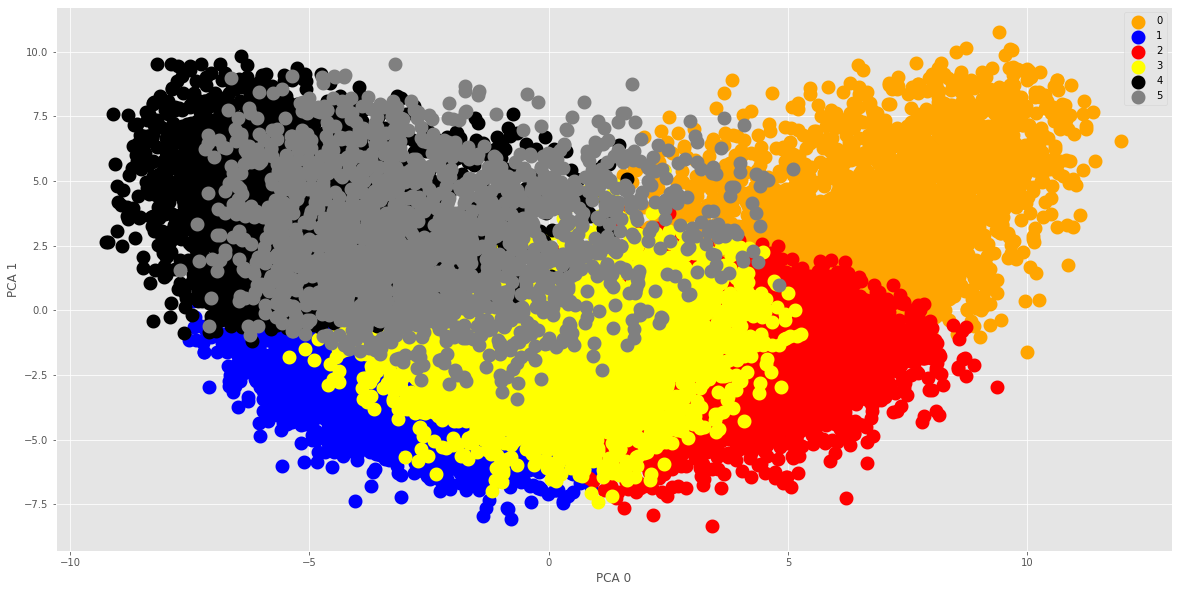

In [46]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# couleur de clusters 
cmap = {0: 'orange', 1: 'blue', 2: 'red', 3: 'yellow', 4: 'black',5:'grey'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group, s=80, linewidths=5, zorder=10)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

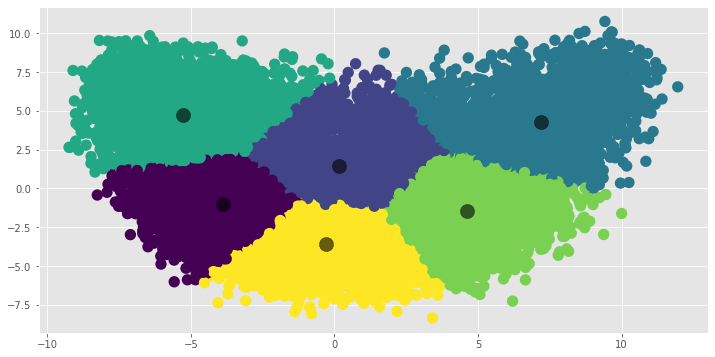

In [42]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(corpus_embeddings)
kmeans = KMeans(n_clusters=6, max_iter=600, tol=0.000001, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

In [20]:
max_len=512
num_classes=len(df['nom_cluster'].unique())
sentences=df_cluster_0['sentence'].tolist()
labels=df_cluster_0['nom_cluster']
len(sentences),len(labels)

(2489, 2489)

In [21]:
# Prepare the model input
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)

/home/titon/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

train_label = np.array([np.array(val) for val in train_label])
val_label = np.array([np.array(val) for val in val_label])


In [23]:
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',)(dbert_layer)
    dense = Dense(64,activation='relu',)(dense)
    # taille 64: représentation latente des données + clusterisation
    dropout= Dropout(0.5)(dense)
    pred = Dense(6, activation='softmax',)(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

2022-12-01 15:18:07.805459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-01 15:18:07.805526: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 15:18:07.805584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hprisser): /proc/driver/nvidia/version does not exist
2022-12-01 15:18:07.834046: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 15:18:08.034700: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but

In [24]:
model_distil=create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

In [25]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

early_stopping= EarlyStopping(patience=3,# stop après 3 epoch
                              monitor='val_loss',# regarder la val_loss
                              mode= 'min',
                              min_delta=0,# changement après 0
                              restore_best_weights=False,
                              verbose=1)

In [26]:
model_distil.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [ ]:
history=model_distil.fit([train_inp,train_mask],train_label,batch_size=64,epochs=10,validation_data=([val_inp,val_mask],val_label),callbacks=early_stopping)

Epoch 1/10


/home/titon/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
